<a href="https://colab.research.google.com/github/nooraovo/nooraovo.github.io/blob/main/ori_LN_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
## prepare
import torch
import time
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

device=torch.device("cpu")
dtype=torch.float


N,D_in,D_out,H=100,10,1,2
# N：input number
# D_in: input dimension
# D_out: output dimension(=1)
# H: hidden dimension(neuron number)

# training case
x=torch.randn(N,D_in,device=device)
torch.nn.init.normal_(x, 0, 1) # initialize x

# generate target
v=torch.rand(D_in,D_out,device=device)
v=v/v.norm() # ||v||=1
y=x.mm(v)
y=y.clamp(min=0)

w_2=torch.ones(H,D_out,device=device)

In [57]:
# original version
learning_rate=0.0005
hidden=[1,2,5,10,15,20,25] # student number
loss_data=np.zeros((7,40000))

for i in range(7):
  H=hidden[i]
  # student network
  w_1=torch.randn(D_in,H,device=device)
  torch.nn.init.normal_(w_1, 0, 0.1) # initialize w
  # sum up all students
  w_2=torch.ones(H,D_out,device=device)

  # begin training
  for it in range(40000):
      #forword pass
      h=x.mm(w_1)
      h_relu=h.clamp(min=0)
      y_hat=h_relu.mm(w_2)

      #compute loss
      loss=(y_hat-y).pow(2).sum()/N/2
      #估计值与真实值之间差值的平方和再取和,替换numpy的square方法
      if(it%100==0):
        print(it,loss)
      loss_data[i][it]=loss.item()

      # backward propagate
      y_hat_grad=2*(y_hat-y)
      w_2_grad=h_relu.t().mm(y_hat_grad)
      h_relu_grad=y_hat_grad.mm(w_2.t())
      h_grad=h_relu_grad.clone()
      h_grad[h<0]=0
      w_1_grad=x.t().mm(h_grad)

      # update student
      w_1=w_1-learning_rate*w_1_grad

0 tensor(0.2308)
100 tensor(0.0002)
200 tensor(1.0860e-06)
300 tensor(7.3955e-09)
400 tensor(5.1187e-11)
500 tensor(5.1452e-13)
600 tensor(3.8828e-13)
700 tensor(3.8828e-13)
800 tensor(3.8828e-13)
900 tensor(3.8828e-13)
1000 tensor(3.8828e-13)
1100 tensor(3.8828e-13)
1200 tensor(3.8828e-13)
1300 tensor(3.8828e-13)
1400 tensor(3.8828e-13)
1500 tensor(3.8828e-13)
1600 tensor(3.8828e-13)
1700 tensor(3.8828e-13)
1800 tensor(3.8828e-13)
1900 tensor(3.8828e-13)
2000 tensor(3.8828e-13)
2100 tensor(3.8828e-13)
2200 tensor(3.8828e-13)
2300 tensor(3.8828e-13)
2400 tensor(3.8828e-13)
2500 tensor(3.8828e-13)
2600 tensor(3.8828e-13)
2700 tensor(3.8828e-13)
2800 tensor(3.8828e-13)
2900 tensor(3.8828e-13)
3000 tensor(3.8828e-13)
3100 tensor(3.8828e-13)
3200 tensor(3.8828e-13)
3300 tensor(3.8828e-13)
3400 tensor(3.8828e-13)
3500 tensor(3.8828e-13)
3600 tensor(3.8828e-13)
3700 tensor(3.8828e-13)
3800 tensor(3.8828e-13)
3900 tensor(3.8828e-13)
4000 tensor(3.8828e-13)
4100 tensor(3.8828e-13)
4200 tensor(

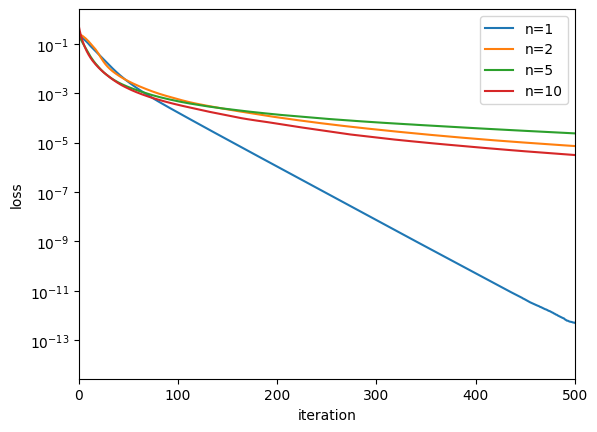

In [65]:
# plot
fig,ax = plt.subplots()
plt.xlim(0,500)
plt.yscale('log')
ax.plot(loss_data[0],label='n=1')
ax.plot(loss_data[1],label='n=2')
ax.plot(loss_data[2],label='n=5')
ax.plot(loss_data[3],label='n=10')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.show()

In [58]:
# Layer Normalization
learning_rate=0.0005
hidden=[10,15,20,25]
eps=1e-6
loss_data2=np.zeros((4,40000))

for i in range(4):
  H=hidden[i]
  w_1=torch.randn(D_in,H,device=device)
  torch.nn.init.normal_(w_1, 0, 0.1)
  bias=torch.randn(N,H,device=device) # additional bias parameter
  w_2=torch.ones(H,D_out,device=device)

  # begin training
  for it in range(40000):
      #forword pass
      h=x.mm(w_1)
      # layer normalization
      mean=h.mean(dim=1,keepdim=True)
      var=h.var(dim=1,keepdim=True)
      h = (h - mean)/(torch.sqrt(var+eps))
      h=h+bias
      h_relu=h.clamp(min=0)
      y_hat=h_relu.mm(w_2)

      #compute loss
      loss=(y_hat-y).pow(2).sum()/N/2
      if(it%100==0):
        print(it,loss)
      loss_data2[i][it]=loss.item()

      # backward propagate
      y_hat_grad=2*(y_hat-y)
      w_2_grad=h_relu.t().mm(y_hat_grad)
      h_relu_grad=y_hat_grad.mm(w_2.t())
      h_grad=h_relu_grad.clone()
      h_grad[h<0]=0
      w_1_grad=(x/(torch.sqrt(var+eps))).t().mm(h_grad)
      bias_grad=h_grad

      # update parameters
      w_1=w_1-learning_rate*w_1_grad
      bias=bias-learning_rate*bias_grad

0 tensor(16.5456)
100 tensor(8.5710)
200 tensor(4.3795)
300 tensor(3.5613)
400 tensor(2.1945)
500 tensor(2.0914)
600 tensor(1.6090)
700 tensor(0.9017)
800 tensor(0.8696)
900 tensor(0.5555)
1000 tensor(0.5750)
1100 tensor(0.7631)
1200 tensor(0.6240)
1300 tensor(0.2649)
1400 tensor(0.3044)
1500 tensor(0.2764)
1600 tensor(0.3353)
1700 tensor(0.2311)
1800 tensor(0.2394)
1900 tensor(0.1526)
2000 tensor(0.2518)
2100 tensor(0.2230)
2200 tensor(0.2772)
2300 tensor(0.2502)
2400 tensor(0.2515)
2500 tensor(0.1189)
2600 tensor(0.1005)
2700 tensor(0.1608)
2800 tensor(0.1380)
2900 tensor(0.1157)
3000 tensor(0.1758)
3100 tensor(0.0956)
3200 tensor(0.1127)
3300 tensor(0.1347)
3400 tensor(0.1068)
3500 tensor(0.1525)
3600 tensor(0.1028)
3700 tensor(0.0933)
3800 tensor(0.2284)
3900 tensor(0.0858)
4000 tensor(0.0616)
4100 tensor(0.0924)
4200 tensor(0.0653)
4300 tensor(0.1620)
4400 tensor(0.1558)
4500 tensor(0.1463)
4600 tensor(0.1336)
4700 tensor(0.0461)
4800 tensor(0.0962)
4900 tensor(0.0847)
5000 tensor

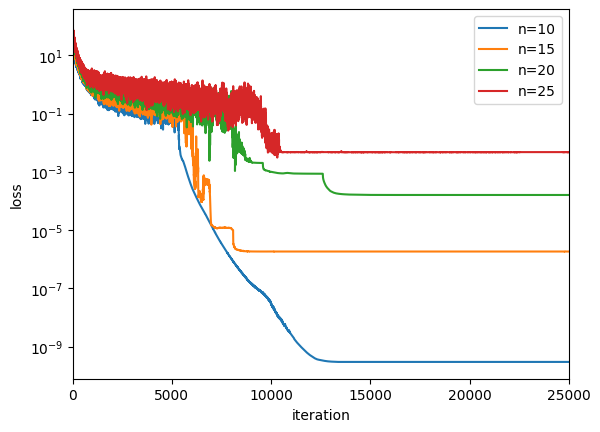

In [66]:
# plot
fig,ax = plt.subplots()
plt.xlim(0,25000)
plt.yscale('log')
ax.plot(loss_data2[0],label='n=10')
ax.plot(loss_data2[1],label='n=15')
ax.plot(loss_data2[2],label='n=20')
ax.plot(loss_data2[3],label='n=25')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.show()

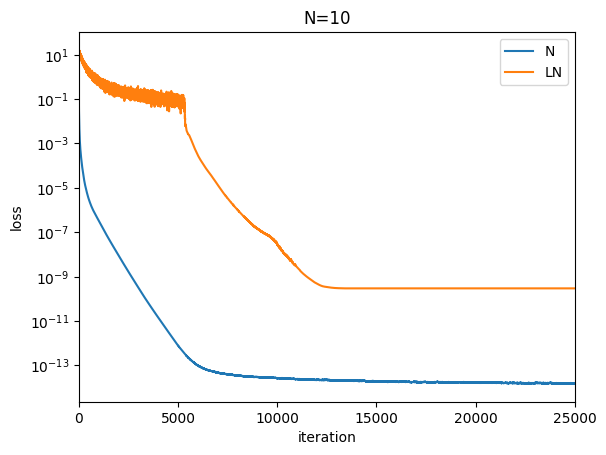

In [67]:
fig,ax = plt.subplots()
plt.xlim(0,25000)
plt.yscale('log')
ax.plot(loss_data[3],label='N')
ax.plot(loss_data2[0],label='LN')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.title('N=10')
plt.show()

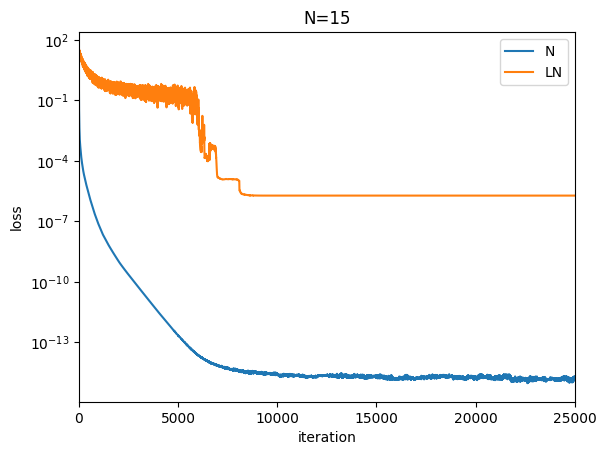

In [68]:
fig,ax = plt.subplots()
plt.xlim(0,25000)
plt.yscale('log')
ax.plot(loss_data[4],label='N')
ax.plot(loss_data2[1],label='LN')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.title('N=15')
plt.show()

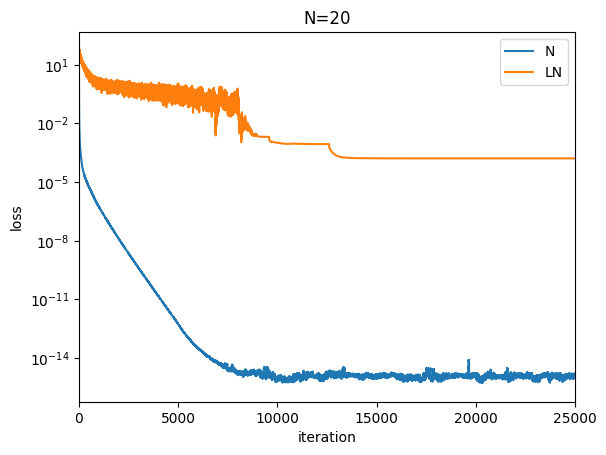

In [69]:
fig,ax = plt.subplots()
plt.xlim(0,25000)
plt.yscale('log')
ax.plot(loss_data[5],label='N')
ax.plot(loss_data2[2],label='LN')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.title('N=20')
plt.show()

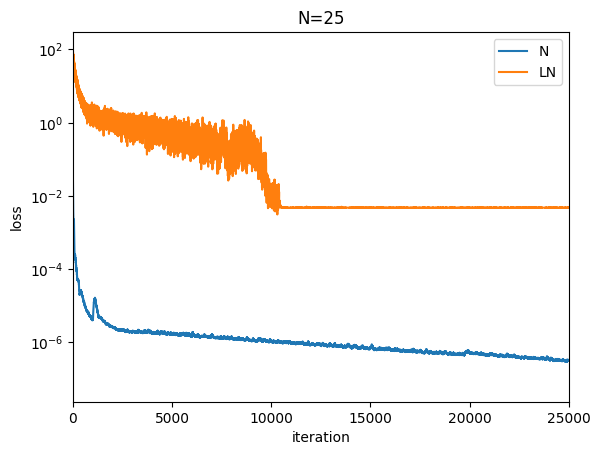

In [70]:
fig,ax = plt.subplots()
plt.xlim(0,25000)
plt.yscale('log')
ax.plot(loss_data[6],label='N')
ax.plot(loss_data2[3],label='LN')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.title('N=25')
plt.show()

In [37]:
# SAM
# compute loss
def loss(w_1):
  h=x.mm(w_1)
  h_relu=h.clamp(min=0)
  y_hat=h_relu.mm(w_2)

  loss=(y_hat-y).pow(2).sum()
  return loss

# compute gradient
def loss_grad(w_1):
  # compute loss
  h=x.mm(w_1)
  h_relu=h.clamp(min=0)
  y_hat=h_relu.mm(w_2)

  y_hat_grad=2*(y_hat-y)
  w_2_grad=h_relu.t().mm(y_hat_grad)
  h_relu_grad=y_hat_grad.mm(w_2.t())
  h_grad=h_relu_grad.clone()
  h_grad[h<0]=0
  w_1_grad=x.t().mm(h_grad)

  return w_1_grad


rou=0.05
learning_rate=0.0005
hidden=[1,2,5,10]
loss_data3=np.zeros((4,2000))

for i in range(4):
  H=hidden[i]
  w_1=torch.randn(D_in,H,device=device)
  torch.nn.init.normal_(w_1, 0, 0.1)
  w_2=torch.ones(H,D_out,device=device)
  # begin training
  for it in range(2000):
      #forword pass
      loss_data3[i][it]=loss(w_1).item()

      # compute gradient
      ori_grad=loss_grad(w_1)
      # compute epi
      epi=rou*ori_grad/ori_grad.norm()
      # compute gradient approximation
      g=loss_grad(epi+w_1)
      # update weights
      w_1-=learning_rate*g

      if(it%100==0):
        print(it,loss(w_1))

0 tensor(56.5423)
100 tensor(0.0892)
200 tensor(0.0006)
300 tensor(0.0006)
400 tensor(0.0006)
500 tensor(0.0006)
600 tensor(0.0006)
700 tensor(0.0006)
800 tensor(0.0006)
900 tensor(0.0006)
1000 tensor(0.0006)
1100 tensor(0.0006)
1200 tensor(0.0006)
1300 tensor(0.0006)
1400 tensor(0.0006)
1500 tensor(0.0006)
1600 tensor(0.0006)
1700 tensor(0.0006)
1800 tensor(0.0006)
1900 tensor(0.0006)
0 tensor(38.1939)
100 tensor(0.1196)
200 tensor(0.0230)
300 tensor(0.0132)
400 tensor(0.0100)
500 tensor(0.0085)
600 tensor(0.0075)
700 tensor(0.0068)
800 tensor(0.0072)
900 tensor(0.0069)
1000 tensor(0.0064)
1100 tensor(0.0062)
1200 tensor(0.0060)
1300 tensor(0.0060)
1400 tensor(0.0061)
1500 tensor(0.0061)
1600 tensor(0.0059)
1700 tensor(0.0061)
1800 tensor(0.0061)
1900 tensor(0.0061)
0 tensor(56.6772)
100 tensor(0.1690)
200 tensor(0.1309)
300 tensor(0.1199)
400 tensor(0.1087)
500 tensor(0.1007)
600 tensor(0.0918)
700 tensor(0.0761)
800 tensor(0.0834)
900 tensor(0.0808)
1000 tensor(0.0748)
1100 tensor(0

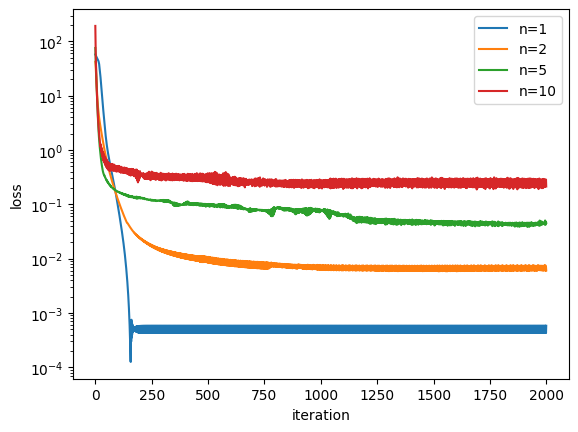

In [38]:
# plot
fig,ax = plt.subplots()
plt.yscale('log')
ax.plot(loss_data3[0],label='n=1')
ax.plot(loss_data3[1],label='n=2')
ax.plot(loss_data3[2],label='n=5')
ax.plot(loss_data3[3],label='n=10')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.show()

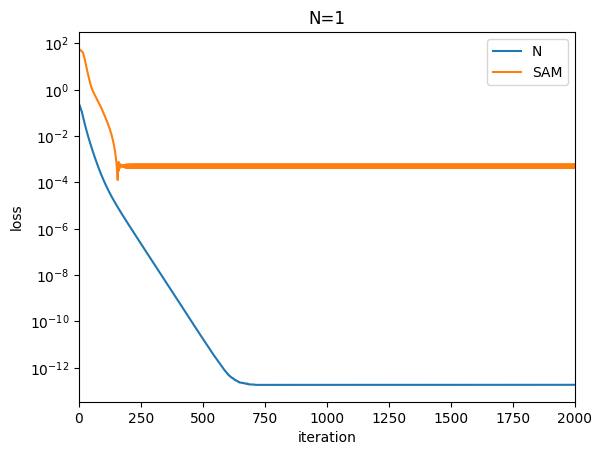

In [40]:
fig,ax = plt.subplots()
plt.yscale('log')
plt.xlim(0,2000)
ax.plot(loss_data[0],label='N')
ax.plot(loss_data3[0],label='SAM')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
plt.title('N=1')
ax.legend()
plt.show()

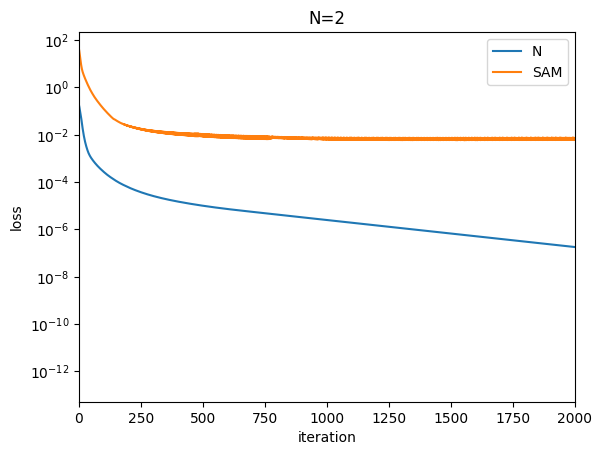

In [41]:
fig,ax = plt.subplots()
plt.xlim(0,2000)
plt.yscale('log')
ax.plot(loss_data[1],label='N')
ax.plot(loss_data3[1],label='SAM')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.title('N=2')
plt.show()

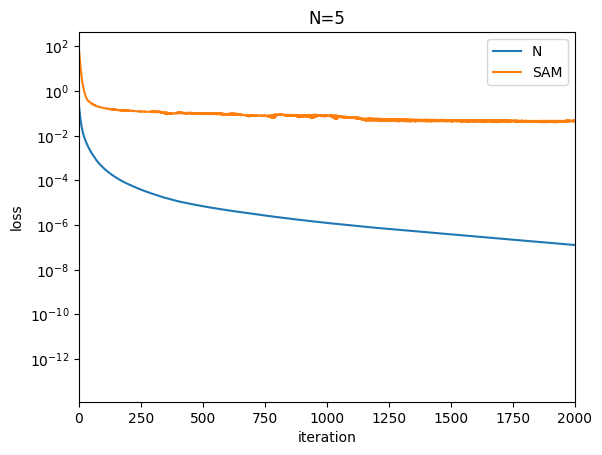

In [42]:
fig,ax = plt.subplots()
plt.xlim(0,2000)
plt.yscale('log')
ax.plot(loss_data[2],label='N')
ax.plot(loss_data3[2],label='SAM')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.title('N=5')
plt.show()

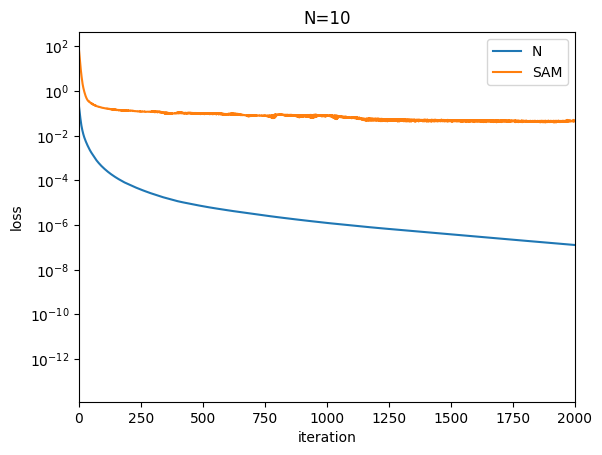

In [43]:
fig,ax = plt.subplots()
plt.xlim(0,2000)
plt.yscale('log')
ax.plot(loss_data[2],label='N')
ax.plot(loss_data3[2],label='SAM')
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.title('N=10')
plt.show()